In [1]:
import numpy
import matplotlib.pyplot as plt
import pandas as pd
import math
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.layers import LSTM
from keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
%matplotlib inline  


/Users/chronowanderer/anaconda3/envs/tensorflow/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
TIME_STEPS = 32
HIDDEN_UNITS = 64
INPUT_UNITS = 2
OUTPUT_UNITS = 180
BATCH_SIZE = 32
TRAIN_SIZE = 300
EFFECTIVE_COEFFICIENT = 0.5
EFFECTIVE_LOC = int(TRAIN_SIZE / EFFECTIVE_COEFFICIENT)
EPOCH = 10
look_back = TIME_STEPS

learning_rate = 0.001


In [3]:
def atan_positive(x, y):
    if (x > 0) & (y > 0):
        theta = math.atan(y / x)
    elif (x == 0) & (y > 0):
        theta = math.pi / 2
    elif (x < 0):
        theta = math.pi + math.atan(y / x)
    elif (x == 0) & (y < 0):
        theta = 3 * math.pi / 2
    elif (x > 0) & (y <= 0):
        theta = 2 * math.pi + math.atan(y / x)
    return theta

def brwnm2(mu1, mu2, a, sigma, h, lentmax):
    locRT = 0
    theta_T = 999
    x = mu1 * h + sigma * numpy.random.randn(lentmax) * math.sqrt(h)
    y = mu2 * h + sigma * numpy.random.randn(lentmax) * math.sqrt(h)
    a_r = a - math.sqrt(h) * sigma / 2.0
    x_start = 0.0
    y_start = 0.0
    w = [x_start]
    z = [y_start] 
    flag = 0
    for k in numpy.arange(1, lentmax):
        w.append(w[k - 1] + x[k])
        z.append(z[k - 1] + y[k])
        if (flag == 0) & (w[k] ** 2 + z[k] ** 2 >= a_r ** 2):
            locRT = k
            theta_T = atan_positive(w[k], z[k]) / 2.0
            flag = 1
    return (w, z, theta_T, locRT)


In [4]:
def semicircular_error(r, t):
    e = r - t
    if e >= 90:
        e = e - 180
    elif e < -90:
        e = e + 180
    return e


In [5]:
numSeries = 500 # training & testing & sequently predicting
numPredict = 100 # complete prediction
tmax = 3.0
h = 0.001
lentmax = int(tmax / h)
T = numpy.linspace(0, tmax, lentmax, endpoint = False)
DATA_i = 0
DATA_f = lentmax - 1
norm, a, sigma = [], [], []
Target, Response, Error, RTloc = [], [], [], []
Dat = []

i = 0
while i < (numSeries + numPredict):
    '''
    norm0 = numpy.random.uniform(0.1, 10)
    a0 = numpy.random.uniform(0.1, 10)
    sigma0 = numpy.random.uniform(0.1, 10)
    RESP = numpy.random.randint(0, 180)
    '''
    norm0 = 1.0
    a0 = 1.0
    sigma0 = 0.1
    RESP = 60
    if RESP == 0:
        RESP = 180;
    mu1 = norm0 * math.cos(2 * RESP * math.pi / 180)
    mu2 = norm0 * math.sin(2 * RESP * math.pi / 180)
    (L_x, L_y, theta, t_loc) = brwnm2(mu1, mu2, a0, sigma0, h, lentmax)
    if t_loc >= EFFECTIVE_LOC:
        norm.append(norm0)
        a.append(a0)
        sigma.append(sigma0)
        Target.append(RESP)
        Response.append(theta / math.pi * 180)
        Error.append(semicircular_error(theta / math.pi * 180, RESP))
        RTloc.append(t_loc)
        temp = []
        for j in numpy.arange(lentmax):
            temp.append([L_x[j], L_y[j]])
        Dat.append(temp)
        i = i + 1

Target = numpy.array(Target)
Response = numpy.array(Response)
Dat = numpy.array(Dat) # all data
Data = Dat[0 : numSeries, :, :] # training & testing & sequently predicting
Data_p = Dat[numSeries : numSeries + numPredict, :, :] # complete prediction

dataset, dataset_t = [], []
for i in numpy.arange(numSeries):
    for j in numpy.arange(lentmax):
        dataset.append(Data[i, j])
        dataset_t.append(Data[i, j])
dataset = numpy.array(dataset)
dataset_p = []
for i in numpy.arange(numPredict):
    for j in numpy.arange(lentmax):
        dataset_p.append(Data_p[i, j])
        dataset_t.append(Data_p[i, j])
predict = numpy.array(dataset_p)
dataset_t = numpy.array(dataset_t)

print dataset.shape, predict.shape, dataset_t.shape


(1500000, 2) (300000, 2) (1800000, 2)


In [6]:
# convert an array of values into a dataset matrix
def create_dataset(series, size, dataset, look_back, output):
    dataX, dataY = [], []
    for k in range(series):
        kk = k * size
        Out = numpy.zeros(180)
        if (output[k] == 180):
            Out[0] = 1
        else:
            Out[int(output[k])] = 1
        for i in range(size - look_back):
            a = dataset[(kk+i) : (kk+i+look_back), :]
            dataX.append(a)            
            dataY.append(Out)
    return numpy.array(dataX), numpy.array(dataY)


In [7]:
TOTAL_TIME = Data.shape[1]

# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
dataset_t = scaler.fit_transform(dataset_t)
dataset = dataset_t[0:numSeries*lentmax, :]
predict = dataset_t[numSeries*lentmax:(numSeries+numPredict)*lentmax, :]

# split into train and test sets
train_size = TRAIN_SIZE
test_size = TOTAL_TIME - train_size + look_back
train, test = [], []
for k in range(numSeries):
    kk = k * TOTAL_TIME
    for t in range(kk, kk+train_size):
        train.append(dataset[t, :])
    for t in range(kk+train_size-look_back, kk+TOTAL_TIME):
        test.append(dataset[t, :])
train = numpy.array(train)
test = numpy.array(test)
        
print train.shape, test.shape, predict.shape

Result = Response
# use this function to prepare the train and test datasets for modeling
trainX, trainY = create_dataset(numSeries, train_size, train, look_back, Result[0:numSeries])
testX, testY = create_dataset(numSeries, test_size, test, look_back, Result[0:numSeries])
predictX, predictY = create_dataset(numPredict, look_back + 1, predict, look_back, Result[numSeries:numSeries+numPredict])

# reshape input to be [samples, time steps, features]
trainX = numpy.reshape(trainX, (trainX.shape[0], look_back, trainX.shape[2]))
testX = numpy.reshape(testX, (testX.shape[0], look_back, testX.shape[2]))
predictX = numpy.reshape(predictX, (predictX.shape[0], look_back, predictX.shape[2]))

print trainX.shape, trainY.shape
print testX.shape, testY.shape
print predictX.shape, predictY.shape


(150000, 2) (1366000, 2) (300000, 2)
(134000, 32, 2) (134000, 180)
(1350000, 32, 2) (1350000, 180)
(100, 32, 2) (100, 180)


In [8]:
# create and fit the LSTM network
model = Sequential()
model.add(LSTM(HIDDEN_UNITS, input_shape=(look_back, INPUT_UNITS)))
model.add(Dense(OUTPUT_UNITS))
model.add(Activation('softmax'))
adam = Adam(lr = learning_rate)   
model.compile(optimizer = adam, loss = 'categorical_crossentropy', metrics = ['accuracy'])
model.fit(trainX, trainY, epochs = EPOCH, batch_size = BATCH_SIZE, verbose = 2)

scores = model.evaluate(testX, testY, verbose = 2)
print('LSTM test score:', scores[0])
print('LSTM test accuracy:', scores[1])

scores_p = model.evaluate(predictX, predictY, verbose = 2)
print('LSTM predict score:', scores_p[0])
print('LSTM predict accuracy:', scores_p[1])


Epoch 1/10
 - 96s - loss: 2.4845 - acc: 0.1290
Epoch 2/10
 - 100s - loss: 2.4662 - acc: 0.1291
Epoch 3/10
 - 96s - loss: 2.4652 - acc: 0.1311
Epoch 4/10
 - 93s - loss: 2.4652 - acc: 0.1313
Epoch 5/10
 - 92s - loss: 2.4649 - acc: 0.1315
Epoch 6/10
 - 93s - loss: 2.4647 - acc: 0.1300
Epoch 7/10
 - 93s - loss: 2.4650 - acc: 0.1304
Epoch 8/10
 - 95s - loss: 2.4652 - acc: 0.1316
Epoch 9/10
 - 93s - loss: 2.4649 - acc: 0.1321
Epoch 10/10
 - 93s - loss: 2.4651 - acc: 0.1306
('LSTM test score:', 2.465755008502536)
('LSTM test accuracy:', 0.134)
('LSTM predict score:', 2.479766969680786)
('LSTM predict accuracy:', 0.17)


In [9]:
# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)
predictPredict = model.predict(predictX)

print predictPredict


[[7.5096401e-11 7.2995721e-11 7.8417606e-11 ... 7.5429586e-11
  7.4557346e-11 7.7001558e-11]
 [7.5096401e-11 7.2995721e-11 7.8417606e-11 ... 7.5429586e-11
  7.4557346e-11 7.7001558e-11]
 [7.5096401e-11 7.2995721e-11 7.8417606e-11 ... 7.5429586e-11
  7.4557346e-11 7.7001558e-11]
 ...
 [7.5096401e-11 7.2995721e-11 7.8417606e-11 ... 7.5429586e-11
  7.4557346e-11 7.7001558e-11]
 [7.5096401e-11 7.2995721e-11 7.8417606e-11 ... 7.5429586e-11
  7.4557346e-11 7.7001558e-11]
 [7.5096401e-11 7.2995721e-11 7.8417606e-11 ... 7.5429586e-11
  7.4557346e-11 7.7001558e-11]]


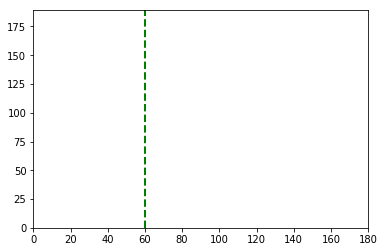

In [11]:
Observation = Response[numSeries : numSeries + numPredict]
Prediction = numpy.argmax(predictPredict, axis = 1)
plt.xlim(0, OUTPUT_UNITS)
plt.hist(Observation, bins = OUTPUT_UNITS, normed = 1, edgecolor = 'None' , facecolor = 'b' , alpha = 0.5)
plt.hist(Prediction, bins = OUTPUT_UNITS, normed = 1, edgecolor = 'None' , facecolor = 'r' , alpha = 0.5)
plt.axvline(RESP, linestyle = 'dashed', linewidth = 2, color='g')
plt.show()
